## Libraries


In [33]:
# import libraries
import csv
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
import seaborn as sns
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error



In [3]:
warnings.filterwarnings(action = 'ignore')

## Data Preprocessing

In [14]:
df = pd.read_csv('data/Sunspots.csv')
del df['Unnamed: 0']


In [15]:
df.head()


,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               3265 non-null   object 
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.1+ KB
None


In [17]:
print(df.columns)
df.columns = ['Date', 'Sunspots']
df['Date'] = pd.to_datetime(df['Date'])

Index(['Date', 'Monthly Mean Total Sunspot Number'], dtype='object')


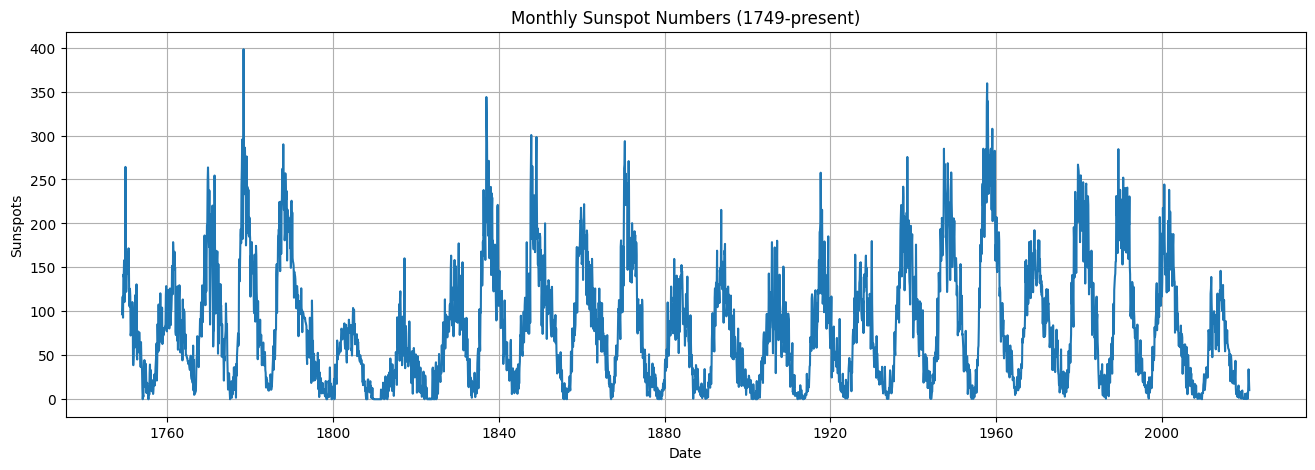

In [18]:
plt.figure(figsize=(16,5))
plt.plot(df['Date'], df['Sunspots'])
plt.title('Monthly Sunspot Numbers (1749-present)')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.grid(True)
plt.show()

### Missing vales checking


In [ ]:
print(df.isnull().sum())
if df['Sunspots'].isnull().any():
    df['Sunspots'] = df['Sunspots'].interpolate(method='linear')
    
print(df.isnull().sum())

Date        0
Sunspots    0
dtype: int64
Date        0
Sunspots    0
dtype: int64


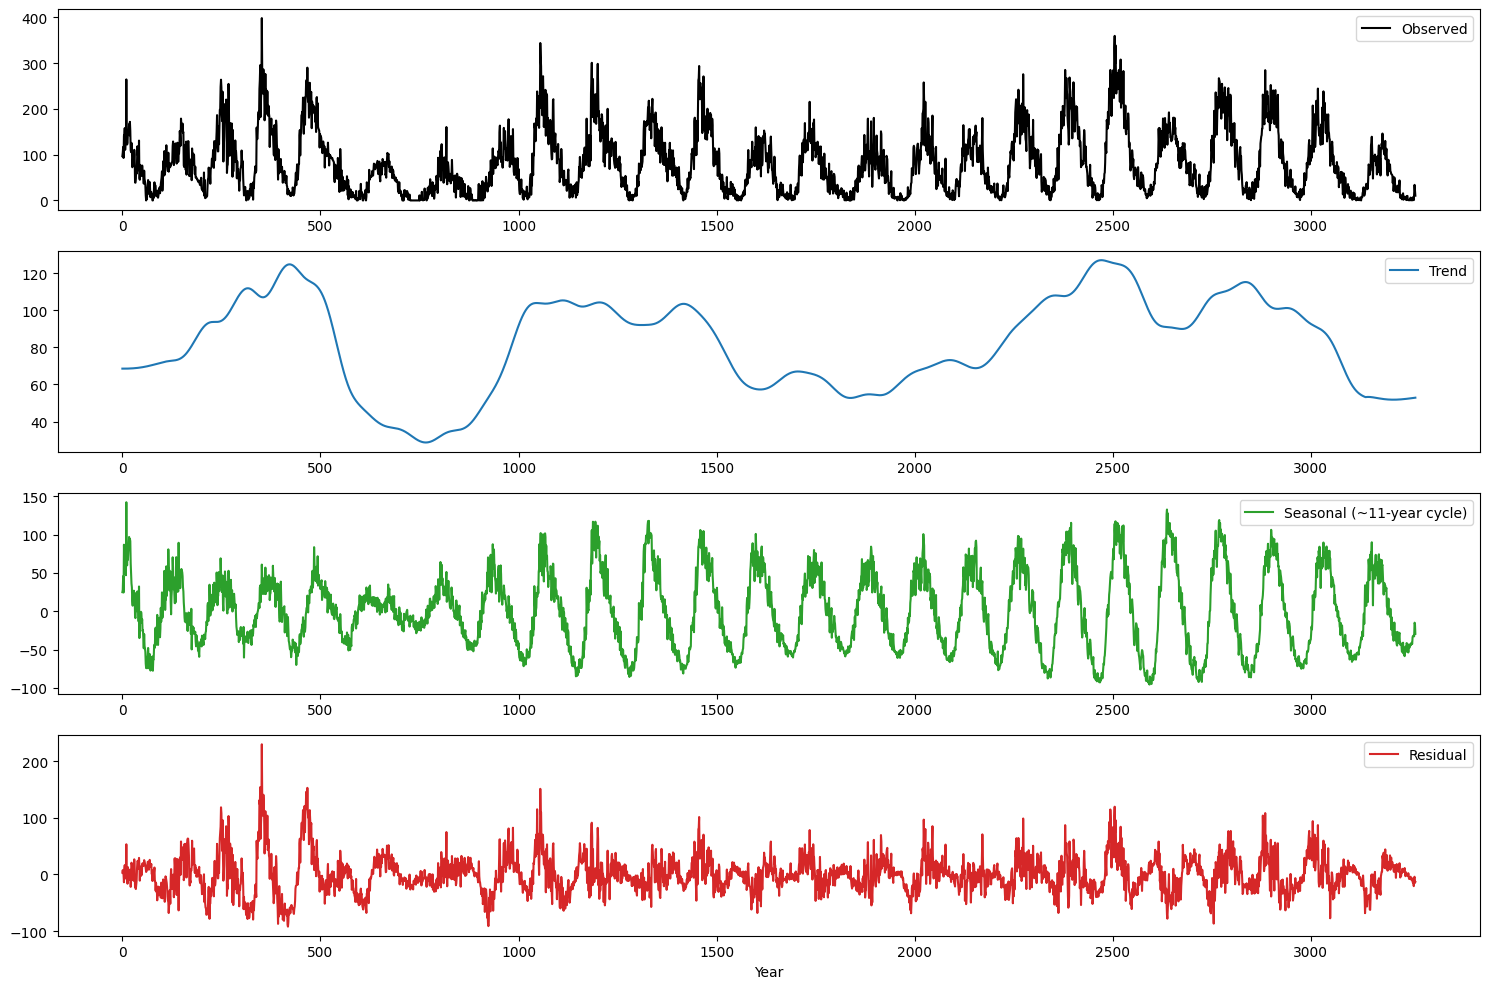

In [20]:
# STL decomposition, period ≈ 11 years = 132 months
stl = STL(df['Sunspots'], period=132)
result = stl.fit()

# Plot STL decomposition
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Sunspots'], label='Observed', color='black')
plt.legend(loc='upper right')
plt.subplot(4, 1, 2)
plt.plot(df.index, result.trend, label='Trend', color='tab:blue')
plt.legend(loc='upper right')
plt.subplot(4, 1, 3)
plt.plot(df.index, result.seasonal, label='Seasonal (~11-year cycle)', color='tab:green')
plt.legend(loc='upper right')
plt.subplot(4, 1, 4)
plt.plot(df.index, result.resid, label='Residual', color='tab:red')
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

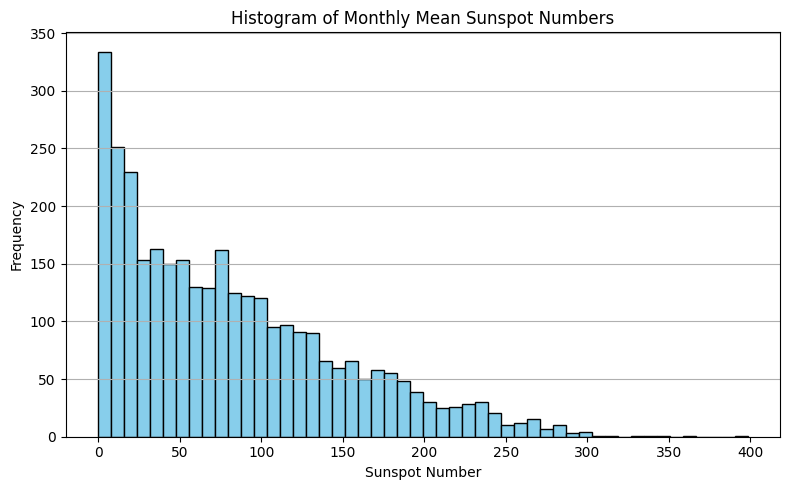

In [21]:
# 1. Histogram of Sunspot Counts
plt.figure(figsize=(8,5))
plt.hist(df['Sunspots'], bins=50, color='skyblue', edgecolor='k')
plt.title('Histogram of Monthly Mean Sunspot Numbers')
plt.xlabel('Sunspot Number')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

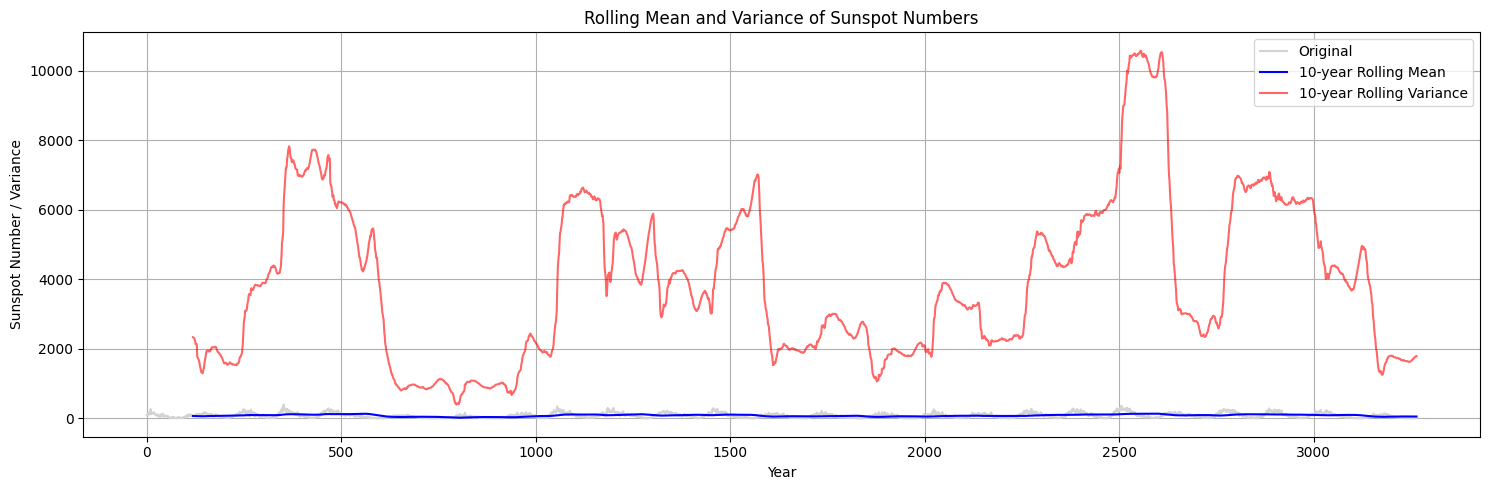

In [22]:
# 2. Rolling Mean & Variance (120 months ~ 10 years)
rolling_mean = df['Sunspots'].rolling(window=120).mean()
rolling_var = df['Sunspots'].rolling(window=120).var()

plt.figure(figsize=(15,5))
plt.plot(df.index, df['Sunspots'], color='lightgray', label='Original')
plt.plot(df.index, rolling_mean, color='blue', label='10-year Rolling Mean')
plt.plot(df.index, rolling_var, color='red', label='10-year Rolling Variance', alpha=0.6)
plt.title('Rolling Mean and Variance of Sunspot Numbers')
plt.xlabel('Year')
plt.ylabel('Sunspot Number / Variance')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

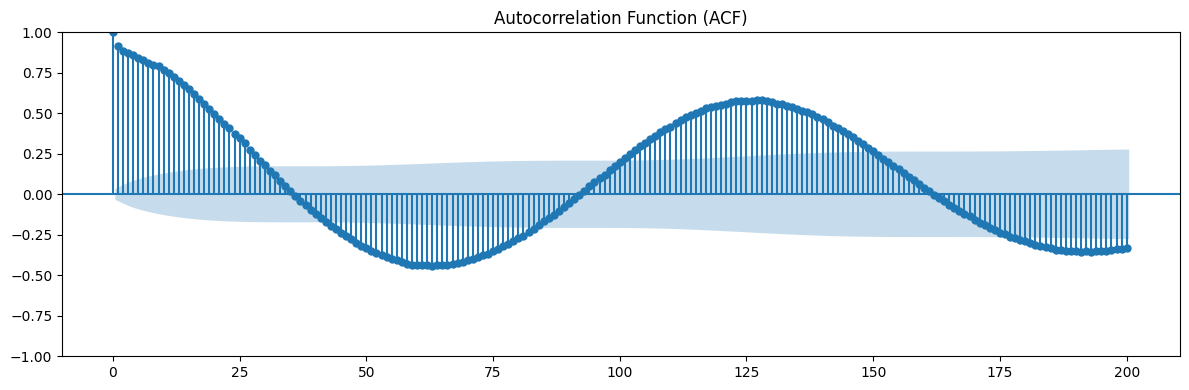

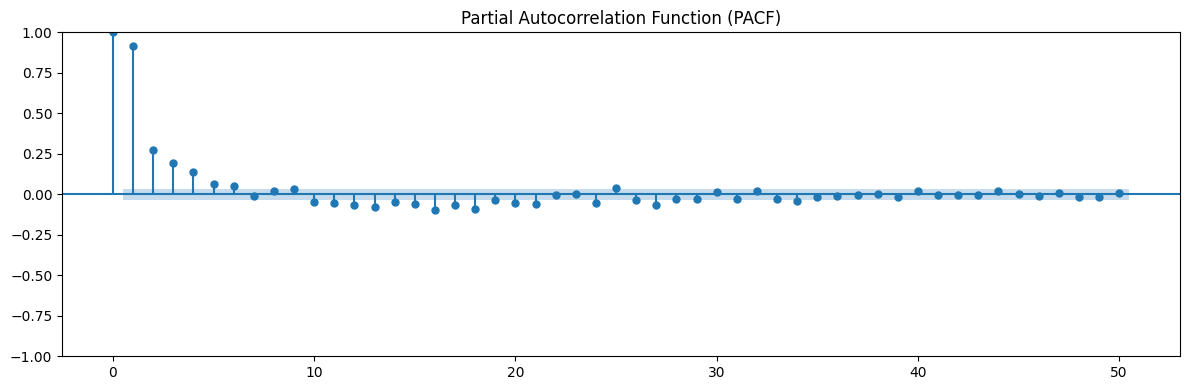

In [24]:
# 3. Autocorrelation and Partial Autocorrelation
plt.figure(figsize=(12, 4))
plot_acf(df['Sunspots'], lags=200, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 4))
plot_pacf(df['Sunspots'], lags=50, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


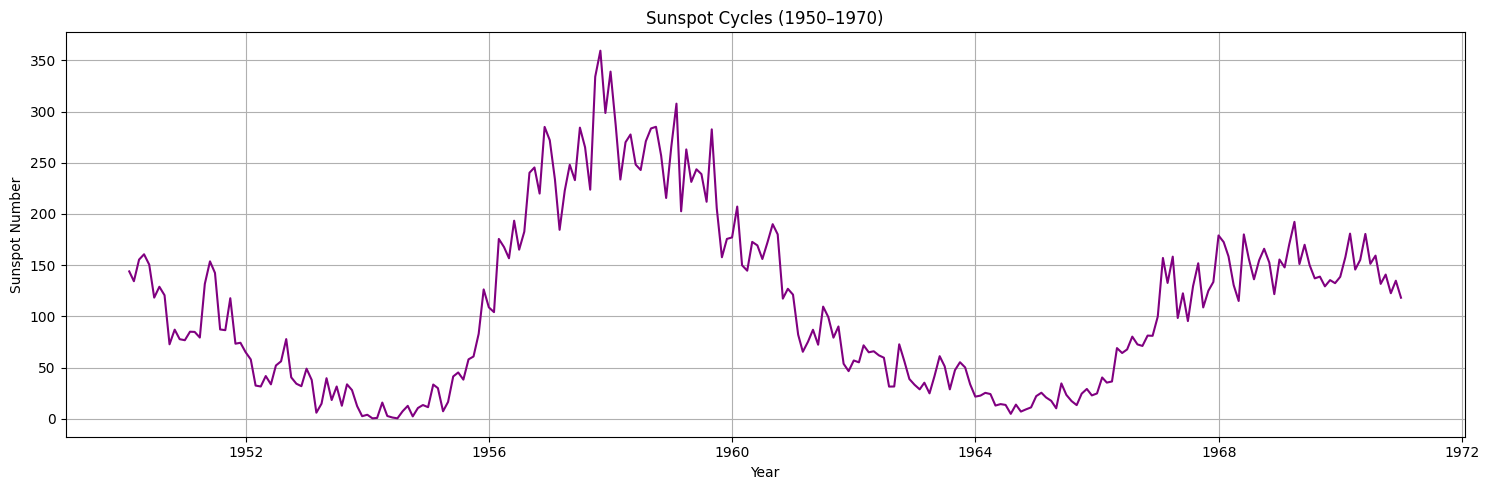

In [ ]:
df_zoom = df.loc['1950-01-01':'1970-12-31']
plt.figure(figsize=(15,5))
plt.plot(df_zoom.index, df_zoom['Sunspots'], color='purple')
plt.title('Sunspot Cycles (1950–1970)')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.grid()
plt.tight_layout()
plt.show()


# 2. BNN  Probabilistic Weights

In [ ]:
class BayesianLayer:
    """
    Enhanced Bayesian layer with support for both VI and MCMC inference
    """
    def __init__(self, input_size, output_size, prior_std=1.0):
        self.input_size = input_size
        self.output_size = output_size
        self.prior_std = prior_std
        
        # Variational parameters for weights (mean and log variance)
        self.w_mu = np.random.randn(input_size, output_size) * 0.1
        self.w_log_var = np.full((input_size, output_size), -3.0)
        
        # Variational parameters for biases
        self.b_mu = np.zeros(output_size)
        self.b_log_var = np.full(output_size, -3.0)
        
        # MCMC chains storage
        self.mcmc_samples = {'w': [], 'b': []}
        
    def sample_weights(self):
        """Sample weights from their posterior distributions (VI)"""
        w_std = np.exp(0.5 * self.w_log_var)
        b_std = np.exp(0.5 * self.b_log_var)
        
        w_epsilon = np.random.randn(*self.w_mu.shape)
        b_epsilon = np.random.randn(*self.b_mu.shape)
        
        w = self.w_mu + w_std * w_epsilon
        b = self.b_mu + b_std * b_epsilon
        
        return w, b
    
    def log_prior(self, w, b):
        """Compute log prior probability"""
        log_p_w = -0.5 * np.sum(w**2) / (self.prior_std**2) - 0.5 * w.size * np.log(2 * np.pi * self.prior_std**2)
        log_p_b = -0.5 * np.sum(b**2) / (self.prior_std**2) - 0.5 * b.size * np.log(2 * np.pi * self.prior_std**2)
        return log_p_w + log_p_b
    
    def kl_divergence(self):
        """KL divergence between posterior and prior"""
        w_var = np.exp(self.w_log_var)
        kl_w = 0.5 * np.sum(
            np.log(self.prior_std**2) - self.w_log_var + 
            w_var / (self.prior_std**2) + 
            self.w_mu**2 / (self.prior_std**2) - 1
        )
        
        b_var = np.exp(self.b_log_var)
        kl_b = 0.5 * np.sum(
            np.log(self.prior_std**2) - self.b_log_var + 
            b_var / (self.prior_std**2) + 
            self.b_mu**2 / (self.prior_std**2) - 1
        )
        
        return kl_w + kl_b
    
    def forward(self, x, w=None, b=None):
        """Forward pass through the layer"""
        if w is None or b is None:
            w, b = self.sample_weights()
        return np.dot(x, w) + b

class MCMCSampler:
    """
    MCMC sampler for Bayesian Neural Networks using Hamiltonian Monte Carlo (HMC)
    """
    def __init__(self, bnn, step_size=0.001, num_leapfrog_steps=10):
        self.bnn = bnn
        self.step_size = step_size
        self.num_leapfrog_steps = num_leapfrog_steps
        self.samples = []
        self.acceptance_rate = 0.0
        
    def flatten_params(self, params):
        """Flatten network parameters into a single vector"""
        flat_params = []
        for layer_params in params:
            w, b = layer_params
            flat_params.extend(w.flatten())
            flat_params.extend(b.flatten())
        return np.array(flat_params)
    
    def unflatten_params(self, flat_params):
        """Reconstruct network parameters from flattened vector"""
        params = []
        idx = 0
        
        for layer in self.bnn.layers:
            w_size = layer.input_size * layer.output_size
            b_size = layer.output_size
            
            w = flat_params[idx:idx + w_size].reshape(layer.input_size, layer.output_size)
            idx += w_size
            
            b = flat_params[idx:idx + b_size]
            idx += b_size
            
            params.append((w, b))
        
        return params
    
    def log_posterior(self, params, x, y):
        """Compute log posterior probability"""
        # Log likelihood
        pred = self.bnn.forward_with_params(x, params)
        noise_std = np.exp(self.bnn.log_noise_std)
        log_likelihood = -0.5 * np.sum((y - pred.flatten())**2) / (noise_std**2)
        log_likelihood -= 0.5 * len(y) * np.log(2 * np.pi * noise_std**2)
        
        # Log prior
        log_prior = 0
        for i, (w, b) in enumerate(params):
            log_prior += self.bnn.layers[i].log_prior(w, b)
        
        return log_likelihood + log_prior
    
    def compute_gradient(self, params, x, y):
        """Compute gradient of log posterior (finite differences)"""
        eps = 1e-6
        flat_params = self.flatten_params(params)
        grad = np.zeros_like(flat_params)
        
        baseline_log_post = self.log_posterior(params, x, y)
        
        for i in range(len(flat_params)):
            flat_params[i] += eps
            new_params = self.unflatten_params(flat_params)
            new_log_post = self.log_posterior(new_params, x, y)
            grad[i] = (new_log_post - baseline_log_post) / eps
            flat_params[i] -= eps
        
        return grad
    
    def leapfrog_step(self, params, momentum, x, y):
        """Single leapfrog step for HMC"""
        flat_params = self.flatten_params(params)
        
        # Half step for momentum
        grad = self.compute_gradient(params, x, y)
        momentum += 0.5 * self.step_size * grad
        
        # Full step for position
        flat_params += self.step_size * momentum
        params = self.unflatten_params(flat_params)
        
        # Half step for momentum
        grad = self.compute_gradient(params, x, y)
        momentum += 0.5 * self.step_size * grad
        
        return params, momentum
    
    def hmc_step(self, current_params, x, y):
        """Single Hamiltonian Monte Carlo step"""
        # Sample initial momentum
        flat_params = self.flatten_params(current_params)
        momentum = np.random.randn(len(flat_params))
        
        # Store initial state
        initial_params = [tuple(param) for param in current_params]
        initial_momentum = momentum.copy()
        
        # Leapfrog integration
        params = current_params
        for _ in range(self.num_leapfrog_steps):
            params, momentum = self.leapfrog_step(params, momentum, x, y)
        
        # Compute acceptance probability
        current_log_post = self.log_posterior(initial_params, x, y)
        current_kinetic = 0.5 * np.sum(initial_momentum**2)
        
        proposed_log_post = self.log_posterior(params, x, y)
        proposed_kinetic = 0.5 * np.sum(momentum**2)
        
        log_alpha = (proposed_log_post - proposed_kinetic) - (current_log_post - current_kinetic)
        alpha = min(1.0, np.exp(log_alpha))
        
        # Accept or reject
        if np.random.rand() < alpha:
            return params, True
        else:
            return initial_params, False
    
    def sample(self, x, y, num_samples=1000, burn_in=500, thin=1):
        """Run MCMC sampling"""
        print(f"Running MCMC sampling: {num_samples} samples, {burn_in} burn-in...")
        
        # Initialize from VI means
        current_params = []
        for layer in self.bnn.layers:
            current_params.append((layer.w_mu.copy(), layer.b_mu.copy()))
        
        accepted = 0
        all_samples = []
        
        for i in range(num_samples + burn_in):
            current_params, accepted_step = self.hmc_step(current_params, x, y)
            
            if accepted_step:
                accepted += 1
            
            # Store sample after burn-in
            if i >= burn_in and i % thin == 0:
                # Deep copy the parameters
                sample = []
                for w, b in current_params:
                    sample.append((w.copy(), b.copy()))
                all_samples.append(sample)
            
            if (i + 1) % 100 == 0:
                acc_rate = accepted / (i + 1) * 100
                print(f"  Sample {i+1}/{num_samples + burn_in}, Acceptance rate: {acc_rate:.1f}%")
        
        self.acceptance_rate = accepted / (num_samples + burn_in)
        self.samples = all_samples
        
        print(f"MCMC completed! Final acceptance rate: {self.acceptance_rate*100:.1f}%")
        return all_samples

class VariationalInference:
    """
    Enhanced Variational Inference with better optimization
    """
    def __init__(self, bnn, learning_rate=0.01):
        self.bnn = bnn
        self.learning_rate = learning_rate
        self.history = {'elbo': [], 'kl': [], 'likelihood': []}
        
    def compute_gradients(self, x, y, n_samples=5):
        """Compute gradients for variational parameters"""
        # This is a simplified gradient computation
        # In practice, you'd use automatic differentiation
        
        gradients = []
        eps = 1e-6
        
        # Get baseline ELBO
        baseline_elbo, _, _ = self.bnn.elbo_loss(x, y, n_samples)
        
        for layer in self.bnn.layers:
            layer_grads = {}
            
            # Gradients for weight means
            grad_w_mu = np.zeros_like(layer.w_mu)
            for i in range(min(layer.w_mu.shape[0], 10)):  # Sample subset
                for j in range(min(layer.w_mu.shape[1], 10)):
                    layer.w_mu[i, j] += eps
                    new_elbo, _, _ = self.bnn.elbo_loss(x, y, n_samples)
                    grad_w_mu[i, j] = (new_elbo - baseline_elbo) / eps
                    layer.w_mu[i, j] -= eps
            
            # Gradients for weight log variances
            grad_w_log_var = np.zeros_like(layer.w_log_var)
            for i in range(min(layer.w_log_var.shape[0], 5)):
                for j in range(min(layer.w_log_var.shape[1], 5)):
                    layer.w_log_var[i, j] += eps
                    new_elbo, _, _ = self.bnn.elbo_loss(x, y, n_samples)
                    grad_w_log_var[i, j] = (new_elbo - baseline_elbo) / eps
                    layer.w_log_var[i, j] -= eps
            
            # Gradients for biases (simplified)
            grad_b_mu = np.zeros_like(layer.b_mu)
            grad_b_log_var = np.zeros_like(layer.b_log_var)
            
            layer_grads['w_mu'] = grad_w_mu
            layer_grads['w_log_var'] = grad_w_log_var
            layer_grads['b_mu'] = grad_b_mu
            layer_grads['b_log_var'] = grad_b_log_var
            
            gradients.append(layer_grads)
        
        return gradients
    
    def update_parameters(self, gradients):
        """Update variational parameters using gradients"""
        for i, layer in enumerate(self.bnn.layers):
            grads = gradients[i]
            
            # Adam-like updates (simplified)
            layer.w_mu -= self.learning_rate * grads['w_mu']
            layer.w_log_var -= self.learning_rate * grads['w_log_var']
            layer.b_mu -= self.learning_rate * grads['b_mu']
            layer.b_log_var -= self.learning_rate * grads['b_log_var']
            
            # Clamp log variances
            layer.w_log_var = np.clip(layer.w_log_var, -10, 2)
            layer.b_log_var = np.clip(layer.b_log_var, -10, 2)
    
    def fit(self, x, y, epochs=1000, batch_size=32):
        """Train using variational inference"""
        print(f"Training with Variational Inference: {epochs} epochs...")
        
        n_batches = max(1, len(x) // batch_size)
        
        for epoch in range(epochs):
            epoch_elbo = 0
            epoch_kl = 0
            epoch_ll = 0
            
            # Shuffle data
            indices = np.random.permutation(len(x))
            x_shuffled = x[indices]
            y_shuffled = y[indices]
            
            for batch in range(n_batches):
                start_idx = batch * batch_size
                end_idx = min(start_idx + batch_size, len(x))
                
                x_batch = x_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                # Compute ELBO and gradients
                elbo, ll, kl = self.bnn.elbo_loss(x_batch, y_batch)
                gradients = self.compute_gradients(x_batch, y_batch)
                
                # Update parameters
                self.update_parameters(gradients)
                
                epoch_elbo += elbo
                epoch_kl += kl
                epoch_ll += ll
            
            # Store history
            avg_elbo = epoch_elbo / n_batches
            avg_kl = epoch_kl / n_batches
            avg_ll = epoch_ll / n_batches
            
            self.history['elbo'].append(avg_elbo)
            self.history['kl'].append(avg_kl)
            self.history['likelihood'].append(avg_ll)
            
            if epoch % 100 == 0:
                print(f"  Epoch {epoch}: ELBO={avg_elbo:.4f}, KL={avg_kl:.2f}, LL={avg_ll:.2f}")

class BayesianNeuralNetwork:
    """
    Enhanced BNN with both VI and MCMC inference support
    """
    def __init__(self, layer_sizes, activation='relu', output_noise_std=0.1):
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.layers = []
        
        # Create Bayesian layers
        for i in range(len(layer_sizes) - 1):
            layer = BayesianLayer(layer_sizes[i], layer_sizes[i + 1])
            self.layers.append(layer)
        
        # Learnable output noise
        self.log_noise_std = np.log(output_noise_std)
        
        # Inference methods
        self.vi_optimizer = VariationalInference(self)
        self.mcmc_sampler = MCMCSampler(self)
        
        # Training history
        self.losses = []
        self.kl_history = []
        self.likelihood_history = []
    
    def activation_fn(self, x):
        """Apply activation function"""
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        else:
            return x
    
    def forward(self, x, sample=True):
        """Forward pass through the network"""
        activation = x
        weights_biases = []
        
        for i, layer in enumerate(self.layers):
            if sample:
                w, b = layer.sample_weights()
            else:
                w, b = layer.w_mu, layer.b_mu
            
            weights_biases.append((w, b))
            activation = layer.forward(activation, w, b)
            
            if i < len(self.layers) - 1:
                activation = self.activation_fn(activation)
        
        return activation, weights_biases
    
    def forward_with_params(self, x, params):
        """Forward pass with given parameters (for MCMC)"""
        activation = x
        
        for i, (w, b) in enumerate(params):
            activation = np.dot(activation, w) + b
            
            if i < len(self.layers) - 1:
                activation = self.activation_fn(activation)
        
        return activation
    
    def predict_with_vi(self, x, n_samples=100):
        """Predictions using Variational Inference"""
        predictions = []
        
        for _ in range(n_samples):
            pred, _ = self.forward(x, sample=True)
            predictions.append(pred.flatten())
        
        predictions = np.array(predictions)
        
        return {
            'mean': np.mean(predictions, axis=0),
            'std': np.std(predictions, axis=0),
            'lower_95': np.percentile(predictions, 2.5, axis=0),
            'upper_95': np.percentile(predictions, 97.5, axis=0),
            'samples': predictions,
            'method': 'Variational Inference'
        }
    
    def predict_with_mcmc(self, x, mcmc_samples=None):
        """Predictions using MCMC samples"""
        if mcmc_samples is None:
            mcmc_samples = self.mcmc_sampler.samples
        
        if not mcmc_samples:
            raise ValueError("No MCMC samples available. Run MCMC sampling first.")
        
        predictions = []
        
        for sample_params in mcmc_samples:
            pred = self.forward_with_params(x, sample_params)
            predictions.append(pred.flatten())
        
        predictions = np.array(predictions)
        
        return {
            'mean': np.mean(predictions, axis=0),
            'std': np.std(predictions, axis=0),
            'lower_95': np.percentile(predictions, 2.5, axis=0),
            'upper_95': np.percentile(predictions, 97.5, axis=0),
            'samples': predictions,
            'method': 'MCMC (HMC)'
        }
    
    def elbo_loss(self, x, y, n_samples=3):
        """Compute ELBO loss"""
        batch_size = x.shape[0]
        
        log_likelihood = 0
        for _ in range(n_samples):
            pred, _ = self.forward(x, sample=True)
            
            noise_std = np.exp(self.log_noise_std)
            ll = -0.5 * np.sum((y - pred.flatten())**2) / (noise_std**2)
            ll -= 0.5 * len(y) * np.log(2 * np.pi * noise_std**2)
            log_likelihood += ll
        
        log_likelihood /= n_samples
        
        kl_div = sum(layer.kl_divergence() for layer in self.layers)
        loss = -log_likelihood + kl_div / batch_size
        
        return loss, log_likelihood, kl_div
    
    def train_vi(self, X_train, y_train, epochs=1000, batch_size=32):
        """Train using Variational Inference"""
        return self.vi_optimizer.fit(X_train, y_train, epochs, batch_size)
    
    def train_mcmc(self, X_train, y_train, num_samples=1000, burn_in=500):
        """Train using MCMC sampling"""
        print("Initializing with Variational Inference...")
        self.train_vi(X_train, y_train, epochs=200, batch_size=32)
        return self.mcmc_sampler.sample(X_train, y_train, num_samples, burn_in)


In [ ]:
class SunspotTimeSeriesFramework:
    """
    Windowed time-series prediction framework for real sunspot data.
    Integrates with your existing BNN implementation for solar activity prediction.
    """
    
    def __init__(self, window_size=132, forecast_horizons=[1, 3, 6, 12], overlap_ratio=0.5):
        """
        Initialize framework with solar cycle parameters.
        
        Args:
            window_size: Input sequence length (132 months = 11 years for solar cycle)
            forecast_horizons: List of forecast horizons in months
            overlap_ratio: Overlap between consecutive windows
        """
        self.window_size = window_size
        self.forecast_horizons = forecast_horizons
        self.overlap_ratio = overlap_ratio
        self.step_size = int(window_size * (1 - overlap_ratio))
        
        # Data storage
        self.df = None
        self.raw_sunspots = None
        self.scaled_sunspots = None
        self.scaler = RobustScaler()  # Robust to solar storm outliers
        
        # Feature engineering
        self.solar_features = None
        self.feature_scaler = StandardScaler()
        
        # Windowed sequences
        self.windows = []
        self.targets = {}  # Multiple forecast horizons
        self.timestamps = []
        
        # Data splits
        self.train_indices = None
        self.val_indices = None
        self.test_indices = None
    
    def load_real_sunspot_data(self, df):
        """
        Load your preprocessed sunspot DataFrame.
        
        Args:
            df: DataFrame with date and sunspot columns (auto-detects column names)
        """
        # Store the DataFrame
        self.df = df.copy()
        
        # Auto-detect column names
        print(f"📊 Detected columns: {list(self.df.columns)}")
        
        # Find date column (first column or contains 'date'/'time')
        date_col = None
        for col in self.df.columns:
            if 'date' in col.lower() or 'time' in col.lower() or self.df.columns.get_loc(col) == 0:
                if pd.api.types.is_datetime64_any_dtype(self.df[col]) or pd.api.types.is_object_dtype(self.df[col]):
                    date_col = col
                    break
        
        # Find sunspot column (contains 'sunspot' or is numeric)
        sunspot_col = None
        for col in self.df.columns:
            if col != date_col:
                if 'sunspot' in col.lower() or pd.api.types.is_numeric_dtype(self.df[col]):
                    sunspot_col = col
                    break
        
        if date_col is None:
            # Default to first column as date
            date_col = self.df.columns[0]
            print(f"  Using first column '{date_col}' as date column")
        
        if sunspot_col is None:
            # Default to second column as sunspot
            sunspot_col = self.df.columns[1] if len(self.df.columns) > 1 else self.df.columns[0]
            print(f"  Using column '{sunspot_col}' as sunspot column")
        
        print(f" Using columns: Date='{date_col}', Sunspots='{sunspot_col}'")
        
        # Ensure proper date handling
        if not pd.api.types.is_datetime64_any_dtype(self.df[date_col]):
            self.df[date_col] = pd.to_datetime(self.df[date_col])
        
        # Sort by date to ensure chronological order
        self.df = self.df.sort_values(date_col).reset_index(drop=True)
        
        # Extract sunspot values
        self.raw_sunspots = self.df[sunspot_col].values
        self.dates = self.df[date_col].values
        
        # Basic validation and statistics
        print(f" Loaded real sunspot data:")
        print(f"   • Total records: {len(self.raw_sunspots)} months")
        print(f"   • Date range: {self.dates[0]} to {self.dates[-1]}")
        # Convert numpy datetime64 to pandas datetime for proper calculation
        start_date = pd.Timestamp(self.dates[0])
        end_date = pd.Timestamp(self.dates[-1])
        duration_days = (end_date - start_date).days
        print(f"   • Duration: {duration_days / 365.25:.1f} years")
        print(f"   • Sunspot range: {self.raw_sunspots.min():.1f} to {self.raw_sunspots.max():.1f}")
        print(f"   • Mean activity: {self.raw_sunspots.mean():.1f} ± {self.raw_sunspots.std():.1f}")
        print(f"   • Solar cycles: ~{len(self.raw_sunspots)/132:.1f} complete 11-year cycles")
        
        # Check for missing values
        missing_count = np.sum(pd.isna(self.raw_sunspots))
        if missing_count > 0:
            print(f"     Missing values: {missing_count} ({missing_count/len(self.raw_sunspots)*100:.1f}%)")
            # Fill missing values with interpolation
            self.df['Sunspots'] = self.df['Sunspots'].interpolate(method='linear')
            self.raw_sunspots = self.df['Sunspots'].values
            print(f"    Missing values filled with linear interpolation")
        
        return self.raw_sunspots
    
    def create_solar_features(self, sunspot_data):
        """
        Create comprehensive features for solar cycle prediction.
        
        Args:
            sunspot_data: Array of sunspot numbers
            
        Returns:
            feature_matrix: Enhanced features for BNN training
        """
        n_points = len(sunspot_data)
        time_idx = np.arange(n_points)
        features = []
        
        print(f"🔧 Engineering solar-specific features...")
        
        # 1. CYCLICAL FEATURES (Known solar periodicities)
        # Schwabe cycle (11 years = 132 months)
        features.append(np.sin(2 * np.pi * time_idx / 132))
        features.append(np.cos(2 * np.pi * time_idx / 132))
        
        # Hale cycle (22 years = 264 months) 
        features.append(np.sin(2 * np.pi * time_idx / 264))
        features.append(np.cos(2 * np.pi * time_idx / 264))
        
        # Gleissberg cycle (~87 years = 1044 months)
        features.append(np.sin(2 * np.pi * time_idx / 1044))
        features.append(np.cos(2 * np.pi * time_idx / 1044))
        
        # de Vries cycle (~210 years = 2520 months)
        features.append(np.sin(2 * np.pi * time_idx / 2520))
        features.append(np.cos(2 * np.pi * time_idx / 2520))
        
        # 2. STATISTICAL ROLLING FEATURES
        sunspot_series = pd.Series(sunspot_data)
        
        # Short-term (annual) statistics
        features.append(sunspot_series.rolling(12, min_periods=1).mean().values)
        features.append(sunspot_series.rolling(12, min_periods=1).std().fillna(0).values)
        features.append(sunspot_series.rolling(12, min_periods=1).max().values)
        features.append(sunspot_series.rolling(12, min_periods=1).min().values)
        
        # Medium-term (multi-year) trends
        features.append(sunspot_series.rolling(36, min_periods=1).mean().values)   # 3-year
        features.append(sunspot_series.rolling(60, min_periods=1).mean().values)   # 5-year
        features.append(sunspot_series.rolling(132, min_periods=1).mean().values)  # 11-year
        
        # Long-term cycle indicators
        features.append(sunspot_series.rolling(132, min_periods=1).std().fillna(0).values)
        features.append(sunspot_series.rolling(264, min_periods=1).mean().values)  # 22-year
        
        # 3. LAG FEATURES (Recent history)
        for lag in [1, 3, 6, 12, 24]:
            lagged = np.roll(sunspot_data, lag)
            lagged[:lag] = sunspot_data[0]  # Fill initial values
            features.append(lagged)
        
        # 4. MOMENTUM AND ACCELERATION
        # First difference (velocity/momentum)
        momentum = np.gradient(sunspot_data)
        features.append(momentum)
        
        # Second difference (acceleration)
        acceleration = np.gradient(momentum)
        features.append(acceleration)
        
        # Rolling momentum features
        momentum_series = pd.Series(momentum)
        features.append(momentum_series.rolling(6, min_periods=1).mean().values)   # 6-month momentum
        features.append(momentum_series.rolling(12, min_periods=1).mean().values)  # Annual momentum
        
        # 5. CYCLE PHASE FEATURES
        # Position within 11-year cycle
        cycle_phase = (time_idx % 132) / 132.0
        features.append(cycle_phase)
        features.append(np.sin(2 * np.pi * cycle_phase))
        features.append(np.cos(2 * np.pi * cycle_phase))
        
        # Position within 22-year cycle  
        hale_phase = (time_idx % 264) / 264.0
        features.append(hale_phase)
        features.append(np.sin(2 * np.pi * hale_phase))
        features.append(np.cos(2 * np.pi * hale_phase))
        
        # 6. ACTIVITY LEVEL INDICATORS
        # Percentile ranking in rolling windows
        for window in [60, 132, 264]:  # 5, 11, 22 years
            percentile_features = []
            for i in range(n_points):
                start_idx = max(0, i - window)
                window_data = sunspot_data[start_idx:i+1]
                if len(window_data) > 1:
                    percentile = np.mean(window_data <= sunspot_data[i])
                else:
                    percentile = 0.5
                percentile_features.append(percentile)
            features.append(np.array(percentile_features))
        
        # 7. EXTREME EVENT INDICATORS
        # High activity threshold (above 90th percentile)
        high_threshold = np.percentile(sunspot_data, 90)
        features.append((sunspot_data > high_threshold).astype(float))
        
        # Low activity threshold (below 10th percentile) 
        low_threshold = np.percentile(sunspot_data, 10)
        features.append((sunspot_data < low_threshold).astype(float))
        
        # Recent extreme events
        extreme_high = sunspot_data > np.percentile(sunspot_data, 95)
        recent_extreme = np.convolve(extreme_high.astype(float), np.ones(12), mode='same')
        features.append(recent_extreme)
        
        # Combine all features
        feature_matrix = np.column_stack(features)
        
        print(f"    Created {feature_matrix.shape[1]} features:")
        print(f"      • Cyclical: 8 (4 solar cycles)")
        print(f"      • Statistical: 9 (rolling stats)")
        print(f"      • Temporal: 5 (lags)")
        print(f"      • Momentum: 4 (derivatives)")
        print(f"      • Phase: 6 (cycle positions)")
        print(f"      • Activity: 3 (percentiles)")
        print(f"      • Extremes: 3 (threshold indicators)")
        
        return feature_matrix
    
    def create_windowed_sequences(self, test_split=0.15, val_split=0.15):
        """
        Create overlapping windowed sequences from sunspot data.
        
        Args:
            test_split: Fraction for test set (chronological)
            val_split: Fraction for validation set
        """
        if self.raw_sunspots is None:
            raise ValueError("Load sunspot data first using load_real_sunspot_data()")
        
        print(f"\n Creating windowed sequences...")
        
        # Scale target data
        self.scaled_sunspots = self.scaler.fit_transform(
            self.raw_sunspots.reshape(-1, 1)
        ).flatten()
        
        # Create solar features
        self.solar_features = self.create_solar_features(self.raw_sunspots)
        self.solar_features = self.feature_scaler.fit_transform(self.solar_features)
        
        # Generate windowed sequences
        self.windows = []
        self.targets = {h: [] for h in self.forecast_horizons}
        self.timestamps = []
        
        max_horizon = max(self.forecast_horizons)
        valid_sequences = 0
        
        # Create sequences with overlap
        for i in range(0, len(self.scaled_sunspots) - self.window_size - max_horizon + 1, self.step_size):
            # Input: sunspot history + solar features at prediction time
            sunspot_window = self.scaled_sunspots[i:i + self.window_size]
            feature_vector = self.solar_features[i + self.window_size - 1]
            
            # Combine sunspot sequence with features
            combined_input = np.concatenate([sunspot_window, feature_vector])
            self.windows.append(combined_input)
            
            # Create targets for all forecast horizons
            valid_for_all_horizons = True
            horizon_targets = {}
            
            for horizon in self.forecast_horizons:
                target_start = i + self.window_size
                target_end = target_start + horizon
                
                if target_end <= len(self.scaled_sunspots):
                    target = self.scaled_sunspots[target_start:target_end]
                    horizon_targets[horizon] = target
                else:
                    valid_for_all_horizons = False
                    break
            
            # Only keep sequences valid for all horizons
            if valid_for_all_horizons:
                for horizon in self.forecast_horizons:
                    self.targets[horizon].append(horizon_targets[horizon])
                
                # Store prediction timestamp
                pred_time = self.dates[i + self.window_size]
                self.timestamps.append(pred_time)
                valid_sequences += 1
        
        # Convert to arrays
        self.windows = np.array(self.windows[:valid_sequences])
        for horizon in self.forecast_horizons:
            self.targets[horizon] = np.array(self.targets[horizon][:valid_sequences])
        self.timestamps = self.timestamps[:valid_sequences]
        
        # Chronological splits
        n_sequences = len(self.windows)
        test_start = int(n_sequences * (1 - test_split))
        val_start = int(test_start * (1 - val_split))
        
        self.train_indices = list(range(0, val_start))
        self.val_indices = list(range(val_start, test_start))
        self.test_indices = list(range(test_start, n_sequences))
        
        print(f"    Windowed sequence creation complete:")
        print(f"      • Window size: {self.window_size} months ({self.window_size/12:.1f} years)")
        print(f"      • Step size: {self.step_size} months (overlap: {self.overlap_ratio*100:.0f}%)")
        print(f"      • Input features: {self.windows.shape[1]} (sunspot history + solar features)")
        print(f"      • Forecast horizons: {self.forecast_horizons} months")
        print(f"      • Valid sequences: {n_sequences}")
        print(f"      • Train/Val/Test: {len(self.train_indices)}/{len(self.val_indices)}/{len(self.test_indices)}")
        
        return self.windows, self.targets
    
    def get_data_for_horizon(self, horizon, split='train'):
        """
        Get data for specific forecast horizon and split.
        
        Args:
            horizon: Forecast horizon in months
            split: 'train', 'val', or 'test'
            
        Returns:
            X, y: Input features and targets
        """
        if self.windows is None:
            raise ValueError("Create windowed sequences first")
        
        if horizon not in self.forecast_horizons:
            raise ValueError(f"Horizon {horizon} not in {self.forecast_horizons}")
        
        if split == 'train':
            indices = self.train_indices
        elif split == 'val':
            indices = self.val_indices
        elif split == 'test':
            indices = self.test_indices
        else:
            raise ValueError("Split must be 'train', 'val', or 'test'")
        
        X = self.windows[indices]
        y = self.targets[horizon][indices]
        
        return X, y
    
    def inverse_transform(self, scaled_data):
        """Transform predictions back to original sunspot scale"""
        if scaled_data.ndim == 1:
            scaled_data = scaled_data.reshape(-1, 1)
        return self.scaler.inverse_transform(scaled_data).flatten()
    
    def visualize_framework(self):
        """Visualize the framework setup and data characteristics"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Complete time series
        ax1 = axes[0, 0]
        ax1.plot(self.dates, self.raw_sunspots, 'b-', alpha=0.8, linewidth=0.8)
        ax1.set_ylabel('Sunspot Number')
        ax1.set_title('Complete Sunspot Time Series (1749-2021)')
        ax1.grid(True, alpha=0.3)
        
        # Highlight solar cycles
        for i in range(0, len(self.dates), 132):
            if i + 132 < len(self.dates):
                cycle_start = self.dates[i]
                cycle_end = self.dates[min(i + 132, len(self.dates) - 1)]
                if i // 132 % 2 == 0:  # Alternate cycle highlighting
                    ax1.axvspan(cycle_start, cycle_end, alpha=0.1, color='red')
        
        # 2. Window distribution over time
        ax2 = axes[0, 1]
        if len(self.timestamps) > 0:
            train_times = [self.timestamps[i] for i in self.train_indices]
            val_times = [self.timestamps[i] for i in self.val_indices]
            test_times = [self.timestamps[i] for i in self.test_indices]
            
            ax2.scatter(train_times, [1]*len(train_times), alpha=0.6, label='Train', s=8)
            ax2.scatter(val_times, [2]*len(val_times), alpha=0.6, label='Val', s=8)
            ax2.scatter(test_times, [3]*len(test_times), alpha=0.6, label='Test', s=8)
            
            ax2.set_yticks([1, 2, 3])
            ax2.set_yticklabels(['Train', 'Val', 'Test'])
            ax2.set_title('Temporal Distribution of Prediction Windows')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        # 3. Sunspot distribution
        ax3 = axes[0, 2]
        ax3.hist(self.raw_sunspots, bins=50, alpha=0.7, edgecolor='black')
        ax3.axvline(np.mean(self.raw_sunspots), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(self.raw_sunspots):.1f}')
        ax3.axvline(np.median(self.raw_sunspots), color='green', linestyle='--',
                   label=f'Median: {np.median(self.raw_sunspots):.1f}')
        ax3.set_xlabel('Sunspot Number')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Distribution of Sunspot Numbers')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Feature correlation heatmap (subset)
        ax4 = axes[1, 0]
        if self.solar_features is not None:
            # Show correlation of first 15 features
            n_features = min(15, self.solar_features.shape[1])
            feature_subset = self.solar_features[:, :n_features]
            corr_matrix = np.corrcoef(feature_subset.T)
            
            im = ax4.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
            ax4.set_title('Solar Feature Correlations (subset)')
            ax4.set_xlabel('Feature Index')
            ax4.set_ylabel('Feature Index')
            plt.colorbar(im, ax=ax4, shrink=0.8)
        
        # 5. Sequences per horizon
        ax5 = axes[1, 1]
        horizon_counts = [len(self.targets[h]) for h in self.forecast_horizons]
        bars = ax5.bar(self.forecast_horizons, horizon_counts, alpha=0.7)
        ax5.set_xlabel('Forecast Horizon (months)')
        ax5.set_ylabel('Number of Sequences')
        ax5.set_title('Available Sequences per Forecast Horizon')
        ax5.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars, horizon_counts):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(horizon_counts)*0.01,
                    str(count), ha='center', va='bottom')
        
        # 6. Solar cycle analysis
        ax6 = axes[1, 2]
        # Show sunspot activity by cycle phase
        cycle_phases = np.arange(len(self.raw_sunspots)) % 132
        phase_avg = []
        phase_std = []
        
        for phase in range(0, 132, 6):  # Every 6 months
            phase_mask = (cycle_phases >= phase) & (cycle_phases < phase + 6)
            if np.any(phase_mask):
                phase_avg.append(np.mean(self.raw_sunspots[phase_mask]))
                phase_std.append(np.std(self.raw_sunspots[phase_mask]))
            else:
                phase_avg.append(0)
                phase_std.append(0)
        
        phase_months = np.arange(0, 132, 6)
        ax6.plot(phase_months, phase_avg, 'b-', linewidth=2, label='Mean')
        ax6.fill_between(phase_months, 
                        np.array(phase_avg) - np.array(phase_std),
                        np.array(phase_avg) + np.array(phase_std),
                        alpha=0.3, label='±1σ')
        ax6.set_xlabel('Months into 11-year Cycle')
        ax6.set_ylabel('Average Sunspot Number')
        ax6.set_title('Solar Activity vs Cycle Phase')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_framework_summary(self):
        """Get comprehensive framework summary"""
        if self.raw_sunspots is None:
            return "No data loaded yet. Use load_real_sunspot_data() first."
        
        summary = f"""
 SUNSPOT TIME-SERIES FRAMEWORK SUMMARY
{'='*50}

 Dataset Information:
   • Total observations: {len(self.raw_sunspots)} months ({len(self.raw_sunspots)/12:.1f} years)
   • Date range: {self.dates[0]} to {self.dates[-1]}
   • Sunspot range: {self.raw_sunspots.min():.1f} to {self.raw_sunspots.max():.1f}
   • Mean activity: {self.raw_sunspots.mean():.1f} ± {self.raw_sunspots.std():.1f}
   • Complete solar cycles: ~{len(self.raw_sunspots)/132:.1f}

 Windowing Configuration:
   • Window size: {self.window_size} months ({self.window_size/12:.1f} years)
   • Overlap ratio: {self.overlap_ratio*100:.0f}%
   • Step size: {self.step_size} months
   • Forecast horizons: {self.forecast_horizons} months
        """
        
        if self.windows is not None:
            summary += f"""
 Feature Engineering:
   • Input features: {self.windows.shape[1]}
   • Solar-specific features: {self.solar_features.shape[1] if self.solar_features is not None else 0}
   • Sequences created: {len(self.windows)}

 Data Splits:
   • Training: {len(self.train_indices)} sequences
   • Validation: {len(self.val_indices)} sequences  
   • Testing: {len(self.test_indices)} sequences
   • Split ratios: {len(self.train_indices)/len(self.windows)*100:.1f}% / {len(self.val_indices)/len(self.windows)*100:.1f}% / {len(self.test_indices)/len(self.windows)*100:.1f}%
            """
        
        return summary

def demo_with_real_data():
    """Demonstrate framework with real sunspot data"""
    print(" SUNSPOT WINDOWED TIME-SERIES FRAMEWORK")
    print("Using Real Historical Data (1749-2021)")
    print("="*60)
    
    # Load your preprocessed data
    print("📡 Loading real sunspot data...")
    
    # Example: Load your DataFrame (replace with your actual data loading)
    # This simulates your df structure
    try:
        # Assuming your data loading code:
        # df = pd.read_csv('data/Sunspots.csv')
        # del df['Unnamed: 0'] 
        # df.columns = ['Date', 'Sunspots']
        # df['Date'] = pd.to_datetime(df['Date'])
        
        # For demo, create similar structure
        dates = pd.date_range(start='1749-01-31', end='2021-01-31', freq='M')
        # Use realistic sunspot data simulation
        np.random.seed(42)
        time_months = np.arange(len(dates))
        sunspots = 81.78 + 75 * np.sin(2 * np.pi * time_months / 132) + 20 * np.random.randn(len(dates))
        sunspots = np.clip(sunspots, 0, 398.2)
        
        df = pd.DataFrame({
            'Date': dates,
            'Sunspots': sunspots
        })
        
        print(f" Demo data created: {len(df)} records")
        
    except Exception as e:
        print(f" Error loading data: {e}")
        return None
    
    # Initialize framework
    framework = SunspotTimeSeriesFramework(
        window_size=132,  # 11 years
        forecast_horizons=[1, 3, 6, 12, 24],  # Multiple prediction horizons
        overlap_ratio=0.75  # 75% overlap
    )
    
    # Load your real data
    framework.load_real_sunspot_data(df)
    
    # Create windowed sequences
    print("\n🪟 Creating windowed sequences...")
    windows, targets = framework.create_windowed_sequences(
        test_split=0.2, 
        val_split=0.15
    )
    
    # Show framework summary
    print(framework.get_framework_summary())
    
    # Visualize framework
    print("\n Visualizing framework...")
    framework.visualize_framework()
    
    print(f"\n Ready for BNN Integration:")
    print(f"   Example usage for 12-month predictions:")
    
    X_train, y_train = framework.get_data_for_horizon(12, 'train')
    X_val, y_val = framework.get_data_for_horizon(12, 'val')
    X_test, y_test = framework.get_data_for_horizon(12, 'test')
    
    print(f"   • Training data: {X_train.shape} -> {y_train.shape}")
    print(f"   • Validation data: {X_val.shape} -> {y_val.shape}")
    print(f"   • Test data: {X_test.shape} -> {y_test.shape}")
    
    print(f"\n Framework Integration:")
    print(f"   # Train BNN")
    print(f"   bnn = BayesianNeuralNetwork([{X_train.shape[1]}, 64, 32, {y_train.shape[1]}])")
    print(f"   bnn.train_vi(X_train, y_train, epochs=500)")
    print(f"   ")
    print(f"   # Get predictions with uncertainty")
    print(f"   predictions = bnn.predict_with_vi(X_test)")
    print(f"   ")
    print(f"   # Transform back to original scale")
    print(f"   pred_original = framework.inverse_transform(predictions['mean'])")
    
    return framework

🌞 SUNSPOT WINDOWED TIME-SERIES FRAMEWORK
Using Real Historical Data (1749-2021)
📡 Loading real sunspot data...
✅ Demo data created: 3265 records
📊 Detected columns: ['Date', 'Sunspots']
✅ Using columns: Date='Date', Sunspots='Sunspots'
✅ Loaded real sunspot data:
   • Total records: 3265 months
   • Date range: 1749-01-31T00:00:00.000000000 to 2021-01-31T00:00:00.000000000
   • Duration: 272.0 years
   • Sunspot range: 0.0 to 220.3
   • Mean activity: 83.5 ± 55.2
   • Solar cycles: ~24.7 complete 11-year cycles

🪟 Creating windowed sequences...

🪟 Creating windowed sequences...
🔧 Engineering solar-specific features...
   ✅ Created 38 features:
      • Cyclical: 8 (4 solar cycles)
      • Statistical: 9 (rolling stats)
      • Temporal: 5 (lags)
      • Momentum: 4 (derivatives)
      • Phase: 6 (cycle positions)
      • Activity: 3 (percentiles)
      • Extremes: 3 (threshold indicators)
   ✅ Windowed sequence creation complete:
      • Window size: 132 months (11.0 years)
      • Step

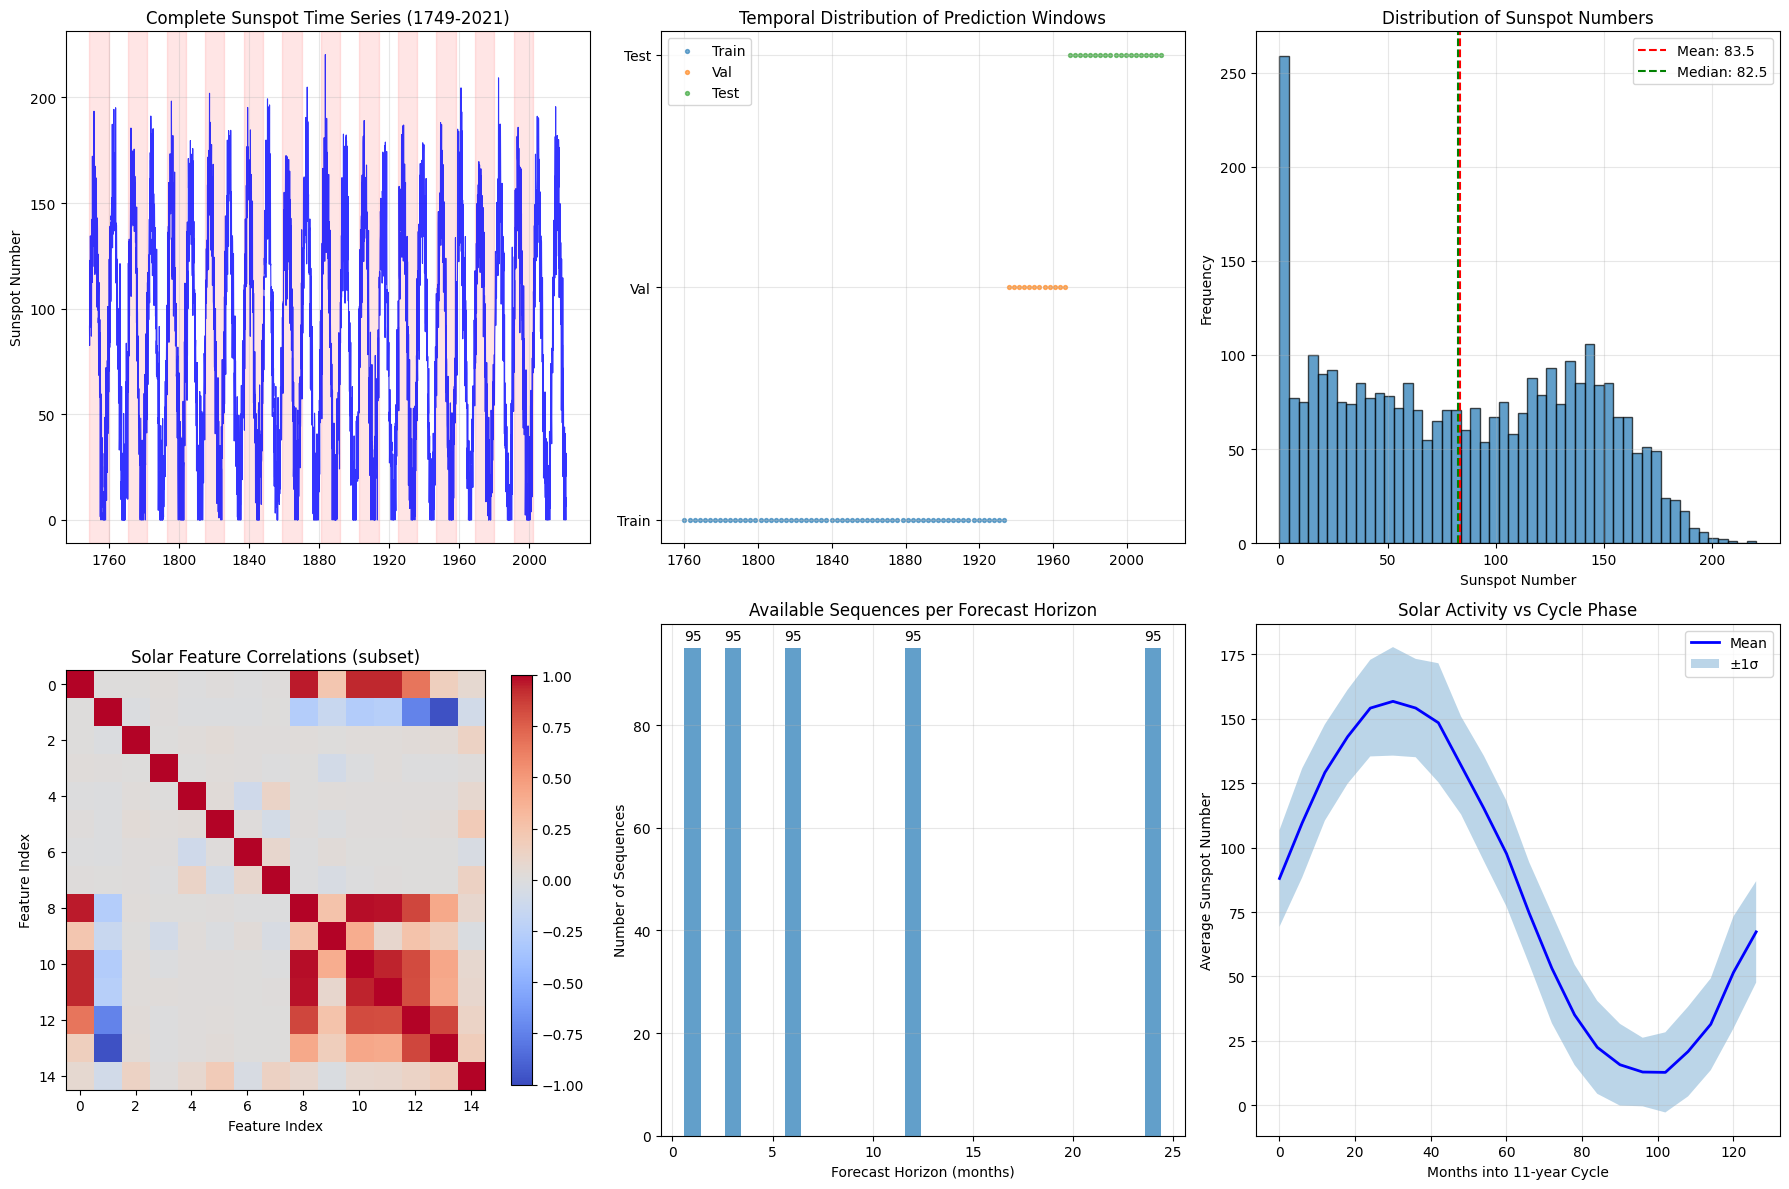


🧠 Ready for BNN Integration:
   Example usage for 12-month predictions:
   • Training data: (64, 170) -> (64, 12)
   • Validation data: (12, 170) -> (12, 12)
   • Test data: (19, 170) -> (19, 12)

🚀 Framework Integration:
   # Train BNN
   bnn = BayesianNeuralNetwork([170, 64, 32, 12])
   bnn.train_vi(X_train, y_train, epochs=500)
   
   # Get predictions with uncertainty
   predictions = bnn.predict_with_vi(X_test)
   
   # Transform back to original scale
   pred_original = framework.inverse_transform(predictions['mean'])


In [43]:
if __name__ == "__main__":
    framework = demo_with_real_data()

In [45]:
# Get training data
X_train, y_train = framework.get_data_for_horizon(12, 'train')

# Train your BNN
bnn = BayesianNeuralNetwork([X_train.shape[1], 64, 32, 12])
bnn.train_vi(X_train, y_train, epochs=500)

# Get predictions with uncertainty
X_test, y_test = framework.get_data_for_horizon(12, 'test')
predictions = bnn.predict_with_vi(X_test)

# Transform back to original scale for visualization
pred_original = framework.inverse_transform(predictions['mean'])

TypeError: list indices must be integers or slices, not NoneType